# Library

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.style.use('ggplot')

import tensorflow as tf
%load_ext tensorboard

import warnings
warnings.filterwarnings('ignore')

import os
import datetime as dt

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow import keras
from tensorflow.keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import time

# Dataset Preprocessing and creation

In [ ]:
data = pd.read_csv("/content/gspc_final.csv")
data.head()

,Date,Open,Close,SAR,MACD,RSI,ATR,MFI,USDX,VIX,EFFR,UNRATE,UMSCENT
0,03-01-2006,1248.290039,1268.800049,NaN,0.000000,NaN,NaN,NaN,89.839996,11.14,4.34,4.7,91.2
1,04-01-2006,1268.800049,1273.459961,1245.73999,0.196947,NaN,NaN,NaN,89.139999,11.37,4.22,4.7,91.2
2,05-01-2006,1273.459961,1273.479980,1245.73999,0.371553,NaN,NaN,NaN,89.330002,11.31,4.24,4.7,91.2
3,06-01-2006,1273.479980,1285.449951,1245.73999,1.030907,NaN,NaN,NaN,88.849998,11.00,4.22,4.7,91.2
4,09-01-2006,1285.449951,1290.150024,1245.73999,1.810155,NaN,NaN,NaN,89.250000,11.13,4.25,4.7,91.2


In [ ]:
data.isna().sum()

Date        0
Open        0
Close       0
SAR         1
MACD        0
RSI         8
ATR        49
MFI        29
USDX        2
VIX         0
EFFR       35
UNRATE      0
UMSCENT     0
dtype: int64

In [ ]:
data.drop(data.index[:49], inplace=True)
data.reset_index(drop=True, inplace=True)

data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
data.set_index("Date",inplace=True)
data.head()

,Open,Close,SAR,MACD,RSI,ATR,MFI,USDX,VIX,EFFR,UNRATE,UMSCENT
Date,,,,,,,,,,,,
2006-03-15,1297.479980,1303.020020,1245.73999,4.059285,63.124058,10.392993,56.832217,89.699997,11.35,4.47,4.7,88.9
2006-03-16,1303.020020,1305.329956,1245.73999,4.826013,66.985742,10.051992,56.670295,89.070000,11.98,4.55,4.7,88.9
2006-03-17,1305.329956,1307.250000,1245.73999,5.571365,81.354102,9.988794,60.493283,88.919998,12.12,4.60,4.7,88.9
2006-03-20,1307.250000,1305.079956,1245.73999,6.122679,81.725270,9.984795,60.708410,89.129997,11.79,4.55,4.7,88.9
2006-03-21,1305.079956,1297.229980,1245.73999,6.260491,68.291731,10.033796,60.639310,89.620003,11.62,4.54,4.7,88.9


In [ ]:
data = data.fillna(data.mean())
data.isna().sum()

Open       0
Close      0
SAR        0
MACD       0
RSI        0
ATR        0
MFI        0
USDX       0
VIX        0
EFFR       0
UNRATE     0
UMSCENT    0
dtype: int64

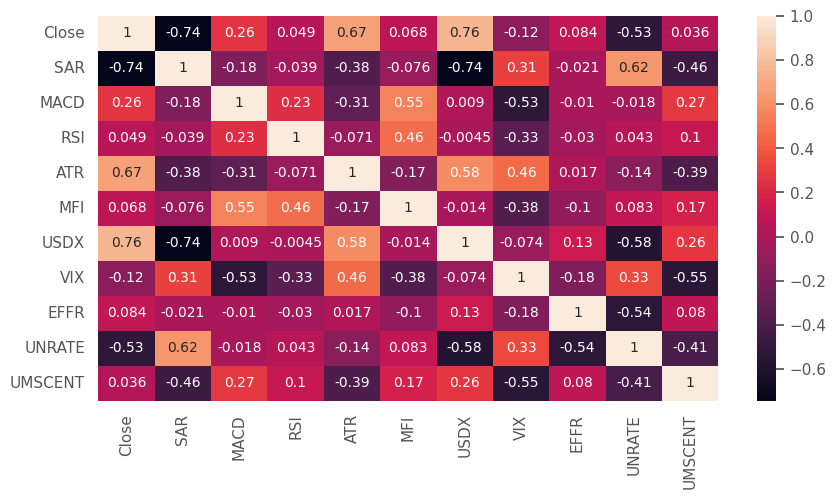

In [ ]:
data = data.iloc[:, 1:]
fig = plt.figure(figsize= (10,5))
sns.heatmap(data.corr(), annot=True)
sns.set_style("whitegrid")
plt.show()

In [ ]:
from skimage.restoration import (denoise_wavelet, estimate_sigma)

data['Close']= denoise_wavelet(data.iloc[:, 0], wavelet='haar',
                                      #method='BayesShrink',
                                      method='VisuShrink',
                                      mode='soft', rescale_sigma = True)
data.head()

,Close,SAR,MACD,RSI,ATR,MFI,USDX,VIX,EFFR,UNRATE,UMSCENT
Date,,,,,,,,,,,
2006-03-15,1297.479562,1245.73999,4.059285,63.124058,10.392993,56.832217,89.699997,11.35,4.47,4.7,88.9
2006-03-16,1297.479562,1245.73999,4.826013,66.985742,10.051992,56.670295,89.070000,11.98,4.55,4.7,88.9
2006-03-17,1297.479562,1245.73999,5.571365,81.354102,9.988794,60.493283,88.919998,12.12,4.60,4.7,88.9
2006-03-20,1297.479562,1245.73999,6.122679,81.725270,9.984795,60.708410,89.129997,11.79,4.55,4.7,88.9
2006-03-21,1297.479562,1245.73999,6.260491,68.291731,10.033796,60.639310,89.620003,11.62,4.54,4.7,88.9


In [ ]:
def DatasetCreation(data_scaled):
    X = data_scaled[:, :-1]
    Y = data_scaled[:, -1]
    return X, Y

def data_split(data, split = 0.2):
  #======= creating training and test data===#
  l1   = int(len(data) * (1- split))
  l2    = len(data) - l1
  data1  = data.iloc[0:l1,:]
  data2   = data.iloc[l1:len(data),:]
  return data1, data2

def min_max_transform(data, feature_range=(0, 1)):
   scaler = MinMaxScaler(feature_range)
   return scaler.fit_transform(data)

def min_max_inverse_transform(data_scaled, min_original, max_original):
    return min_original +  data_scaled*(max_original - min_original)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    return (np.mean(np.abs((y_true - y_pred)/(y_true))*100)) #some issues with zero denominator

def rmse(y_true, y_pred):
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

# Linear

In [ ]:
from sklearn.linear_model import LinearRegression

def build_linear_model():

  model = LinearRegression()
  return model

build_linear_model()

LinearRegression()

In [ ]:
def LinearRegression_model(data, test_split = 0.2):

    train_data, test_data = data_split(data, test_split)

    min_train, max_train  = train_data["Close"].min(), train_data["Close"].max()
    min_test, max_test   =  test_data["Close"].min(), test_data["Close"].max()

    train_data_scaled  =  min_max_transform(train_data)
    test_data_scaled   = min_max_transform(test_data)

    x_train,y_train = DatasetCreation(train_data_scaled)
    x_test,y_test = DatasetCreation(test_data_scaled)

    model = build_linear_model()
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)

    test_pred = min_max_inverse_transform(y_pred, min_test, max_test)
    test_true = min_max_inverse_transform(y_test, min_test, max_test)

    r = rmse(test_true, test_pred)
    print(f"Linear RMSE: {r}")

    return r

In [ ]:
linear = LinearRegression_model(data, test_split = 0.2)

Linear RMSE: 1102.7407924504475


# Ridge

In [ ]:
def build_ridge_model(alpha=1.0):
  ridge_model = Ridge(alpha=alpha)
  return ridge_model

build_ridge_model()

Ridge()

In [ ]:
def RidgeRegression_model(data, test_split = 0.2, alpha=1.0):

    train_data, test_data = data_split(data, test_split)

    min_train, max_train  = train_data["Close"].min(), train_data["Close"].max()
    min_test, max_test   =  test_data["Close"].min(), test_data["Close"].max()

    train_data_scaled  =  min_max_transform(train_data)
    test_data_scaled   = min_max_transform(test_data)

    x_train,y_train = DatasetCreation(train_data_scaled)
    x_test,y_test = DatasetCreation(test_data_scaled)

    model = build_ridge_model(alpha)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)

    test_pred = min_max_inverse_transform(y_pred, min_test, max_test)
    test_true = min_max_inverse_transform(y_test, min_test, max_test)

    r = rmse(test_true, test_pred)
    print(f"Ridge RMSE: {r}")

    return r

In [ ]:
ridge = RidgeRegression_model(data, test_split = 0.2,alpha=100.0)

Ridge RMSE: 992.4558393203508


# Lasso

In [ ]:
def build_lasso_model(alpha=1.0):
  lasso_model = Lasso(alpha=alpha)
  return lasso_model

build_lasso_model()

Lasso()

In [ ]:
def LassoRegression_model(data, test_split = 0.2, alpha=1.0):

    train_data, test_data = data_split(data, test_split)

    min_train, max_train  = train_data["Close"].min(), train_data["Close"].max()
    min_test, max_test   =  test_data["Close"].min(), test_data["Close"].max()

    train_data_scaled  =  min_max_transform(train_data)
    test_data_scaled   = min_max_transform(test_data)

    x_train,y_train = DatasetCreation(train_data_scaled)
    x_test,y_test = DatasetCreation(test_data_scaled)

    model = build_lasso_model(alpha)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)

    test_pred = min_max_inverse_transform(y_pred, min_test, max_test)
    test_true = min_max_inverse_transform(y_test, min_test, max_test)

    r = rmse(test_true, test_pred)
    print(f"Lasso RMSE: {r}")

    return r

In [ ]:
lasso = LassoRegression_model(data, test_split = 0.2, alpha=1.0)

Lasso RMSE: 649.0209683355957


# Polynomial

In [ ]:
def build_poly_model(degree=2,alpha=1.0):
  poly_model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
  return poly_model

build_poly_model()

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('ridge', Ridge())])

In [ ]:
def PolynomialRegression_model(data, test_split = 0.2, degree=2, alpha=1.0):

    train_data, test_data = data_split(data, test_split)

    min_train, max_train  = train_data["Close"].min(), train_data["Close"].max()
    min_test, max_test   =  test_data["Close"].min(), test_data["Close"].max()

    train_data_scaled  =  min_max_transform(train_data)
    test_data_scaled   = min_max_transform(test_data)

    x_train,y_train = DatasetCreation(train_data_scaled)
    x_test,y_test = DatasetCreation(test_data_scaled)

    model = build_poly_model(degree,alpha)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)

    test_pred = min_max_inverse_transform(y_pred, min_test, max_test)
    test_true = min_max_inverse_transform(y_test, min_test, max_test)

    r = rmse(test_true, test_pred)
    print(f"Polynomial RMSE: {r}")

    return r

In [ ]:
polynomial = PolynomialRegression_model(data, test_split = 0.2, degree = 1, alpha = 10)

Polynomial RMSE: 1055.9643743923853


#  Elastic Net

In [ ]:
def build_elastic_net_model(alpha=2.0,l1_ratio=0.1):
  elastic_net_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
  return elastic_net_model

build_elastic_net_model()

ElasticNet(alpha=2.0, l1_ratio=0.1)

In [ ]:
def ElasticRegression_model(data, alpha, l1_ratio, test_split = 0.2):

    train_data, test_data = data_split(data, test_split)

    min_train, max_train  = train_data["Close"].min(), train_data["Close"].max()
    min_test, max_test   =  test_data["Close"].min(), test_data["Close"].max()

    train_data_scaled  =  min_max_transform(train_data)
    test_data_scaled   = min_max_transform(test_data)

    x_train,y_train = DatasetCreation(train_data_scaled)
    x_test,y_test = DatasetCreation(test_data_scaled)


    model = build_elastic_net_model(alpha,l1_ratio)
    print(model)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)

    test_pred = min_max_inverse_transform(y_pred, min_test, max_test)
    test_true = min_max_inverse_transform(y_test, min_test, max_test)

    r = rmse(test_true, test_pred)
    print(f"Elastic RMSE: {r}")

    return r

In [ ]:
alpha = 5
l1_ratio = 0.1
elastic = ElasticRegression_model(data, alpha, l1_ratio, test_split = 0.2)
print(elastic)

ElasticNet(alpha=5, l1_ratio=0.1)
Elastic RMSE: 649.0209683355957
649.0209683355957


# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

def build_logistic_model():
  logistic_model = LogisticRegression()
  return logistic_model

build_logistic_model()

LogisticRegression()

In [ ]:
def LogisticRegression_model(data, test_split = 0.2):

    train_data, test_data = data_split(data, test_split)

    min_train, max_train  = train_data["Close"].min(), train_data["Close"].max()
    min_test, max_test   =  test_data["Close"].min(), test_data["Close"].max()

    train_data_scaled  =  min_max_transform(train_data)
    test_data_scaled   = min_max_transform(test_data)

    x_train,y_train = DatasetCreation(train_data_scaled)
    x_test,y_test = DatasetCreation(test_data_scaled)


    model = build_logistic_model()
    print(model)
    model.fit(x_train, y_train)

    y_pred = model.predict_proba(x_test)

    test_pred = min_max_inverse_transform(y_pred, min_test, max_test)
    test_true = min_max_inverse_transform(y_test, min_test, max_test)

    r = rmse(test_true, test_pred)
    print(f"Logistic Regression RMSE: {r}")

    return r

In [ ]:
lr = LogisticRegression_model(data, test_split = 0.2)
print(lr)

LogisticRegression()


ValueError: Unknown label type: 'continuous'

# Visualization

In [ ]:
data = {
    'methods' : ['Linear','Ridge','Lasso','Polynomial','Elastic Net'],
    'rmse' : [linear,ridge,lasso,polynomial,elastic]
}

data = pd.DataFrame(data)
print(data['methods'])

0         Linear
1          Ridge
2          Lasso
3     Polynomial
4    Elastic Net
Name: methods, dtype: object


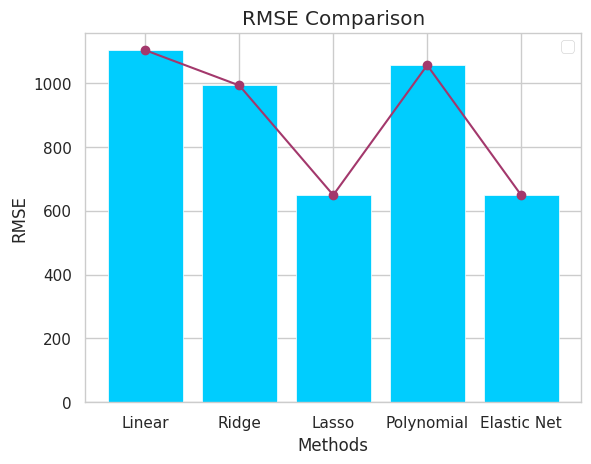

In [ ]:
plt.bar(data['methods'], data['rmse'], color='#00CDFE')
plt.plot(data['rmse'], marker='o', color='#A3386C')

plt.xlabel('Methods')
plt.ylabel('RMSE')
plt.title('RMSE Comparison')
plt.legend()
plt.show()

## Various Techniques

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
models_data = pd.read_excel("/content/VariousModelResultsRMSE.xlsx")
models_data.head()

,Technique,Dataset,RMSE,Unnamed: 3,Unnamed: 4
0,Linear Regression,S&P 500,1102.740792,NaN,NaN
1,RNN ( Single Layer ),S&P 500,48.261807,NaN,NaN
2,LSTM ( Single Layer ),S&P 500,50.319978,NaN,NaN
3,LSTM ( Multi Layer ),S&P 500,61.090335,NaN,NaN
4,Bi-LSTM,S&P 500,61.095979,NaN,NaN


In [ ]:
models_data = models_data.drop(["Dataset","Unnamed: 3","Unnamed: 4"],axis=1)
models_data

,Technique,RMSE
0,Linear Regression,1102.740792
1,RNN ( Single Layer ),48.261807
2,LSTM ( Single Layer ),50.319978
3,LSTM ( Multi Layer ),61.090335
4,Bi-LSTM,61.095979
5,LSTM-ARO,40.048673
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,Models,Alpha


In [ ]:
models_data = models_data[1:]
models_data

,Technique,RMSE
1,RNN ( Single Layer ),48.261807
2,LSTM ( Single Layer ),50.319978
3,LSTM ( Multi Layer ),61.090335
4,Bi-LSTM,61.095979
5,LSTM-ARO,40.048673


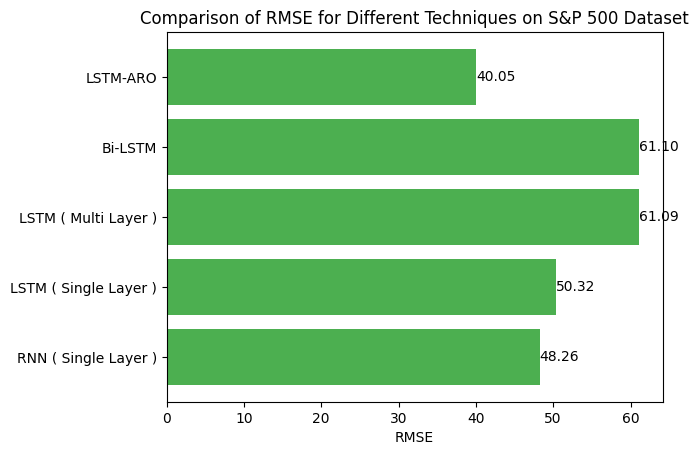

In [ ]:
import matplotlib.pyplot as plt

# Assuming models_data is a DataFrame with 'Technique' and 'RMSE' columns

plt.barh(models_data['Technique'], models_data['RMSE'], color='#4CAF50')
plt.xlabel('RMSE')
plt.title('Comparison of RMSE for Different Techniques on S&P 500 Dataset')

for index, value in enumerate(models_data['RMSE']):
    plt.text(value, index, f'{value:.2f}', ha='left', va='center')

plt.show()

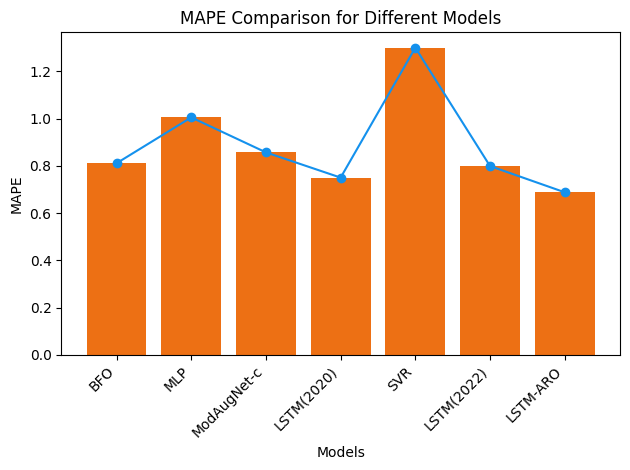

In [ ]:
import matplotlib.pyplot as plt
models = ["BFO", "MLP", "ModAugNet-c", "LSTM(2020)", "SVR", "LSTM(2022)", "LSTM-ARO"]
mape_values = [0.8108, 1.0049, 0.8568, 0.75, 1.30, 0.7989, 0.6879]

plt.bar(models, mape_values, color='#ED7014')
plt.plot(models, mape_values, marker='o', color='#1491ED', linestyle='-')

plt.xlabel('Models')
plt.ylabel('MAPE')
plt.title('MAPE Comparison for Different Models')

plt.xticks(rotation=45, ha="right")
plt.tight_layout()  # Ensures the labels fit within the figure area

plt.show()